## Parte 1
Demostrar que $$\frac{\partial \sigma (x)}{\partial x} = \sigma(x)(1-\sigma(x))$$ donde $\sigma(x) = \frac{1}{1+e^{-x}}$  
  
Demostracion:  
  
$$\frac{\partial \sigma (x)}{\partial x} = -\left(1+e^{-x}\right)^{-2}\left(e^{-x}\right)(-1)$$  
$$= \frac{e^{-x}}{\left(1+e^{-x}\right)^2}$$  
$$=\left(\frac{1}{1+e^{-x}}\right) \left(\frac{e^{-x}}{1+e^{-x}}\right)$$  
$$= \sigma(x)\left(\frac{1-1+e^{-x}}{1+e^{-x}}\right)$$  
$$= \sigma(x)\left(\frac{1+e^{-x}}{1+e^{-x}}-\frac{1}{1+e^{-x}}\right)$$  
$$= \sigma(x)(1-\sigma(x))$$  
$$\therefore \frac{\partial \sigma (x)}{\partial x} = \sigma(x)(1-\sigma(x))$$

## Parte 2.

In [148]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [149]:
housing = pd.read_csv("./Datos/train.csv")
housing.head().T

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
...,...,...,...,...,...
MoSold,2,5,9,2,12
YrSold,2008,2007,2008,2006,2008
SaleType,WD,WD,WD,WD,WD
SaleCondition,Normal,Normal,Normal,Abnorml,Normal


In [150]:
#Tipos de variables
housing.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [151]:
#Variables con valores nulos
housing.columns[housing.isna().sum() > 0]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Se eliminarán todas las variables que tengan más del 10% de valores nulos.

In [152]:
porcentaje_nulos = housing[housing.columns[housing.isna().sum() > 0]].isna().sum()/housing.shape[0]
eliminar_variables = porcentaje_nulos[porcentaje_nulos>=.1]
eliminar_variables

LotFrontage    0.177397
Alley          0.937671
FireplaceQu    0.472603
PoolQC         0.995205
Fence          0.807534
MiscFeature    0.963014
dtype: float64

In [153]:
housing.drop(columns = eliminar_variables.index.values,inplace=True)
housing.drop(columns = "Id", inplace = True)

In [154]:
#Vemos cuales son las variables con valores nulos restantes
(housing.columns)[housing[housing.GarageCond.notna()].isna().sum()>0]

Index(['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical'],
      dtype='object')

In [155]:
#Total de observaciones de la base
n_original = housing.shape[0]

In [156]:
#Se decidió no imputar valores (por posible riesgo de sesgo), ya que al quitar
#todas las observaciones con valores nulos, se pierde menos del 10% de la base
#original.

#Una alternativa de modelado, sería imputar los valores de una manera cuidados
#(intentando entender el por qué faltan valores)
housing  = housing[housing.GarageCond.notna()]
housing.shape

(1379, 74)

In [157]:
housing = housing[housing.BsmtExposure.notna()]

In [158]:
(housing.columns)[housing.isna().sum()>0]

Index(['MasVnrType', 'MasVnrArea', 'BsmtFinType2', 'Electrical'], dtype='object')

In [159]:
housing.isna().sum()[housing.isna().sum()>0]

MasVnrType      8
MasVnrArea      8
BsmtFinType2    1
Electrical      1
dtype: int64

In [160]:
housing  = housing[housing.MasVnrType.notna()]
housing.shape

(1340, 74)

In [161]:
housing.isna().sum()[housing.isna().sum()>0]

BsmtFinType2    1
Electrical      1
dtype: int64

In [162]:
housing  = housing[housing.BsmtFinType2.notna()]
housing.shape

(1339, 74)

In [163]:
housing  = housing[housing.Electrical.notna()]
housing.shape

(1338, 74)

In [164]:
housing.shape[0]/n_original

0.9164383561643835

In [165]:
#Guardamos todas las variables numéricas
variables_num = housing.columns[housing.dtypes != "object"]
variables_num

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [166]:
#Hacemos lo propio con las categóricas
variables_cat = housing.columns[housing.dtypes == "object"]
variables_cat

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

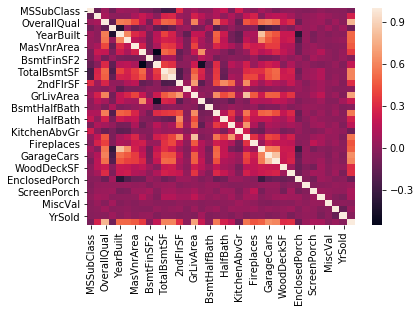

In [167]:
sns.heatmap(housing[variables_num].corr())

In [168]:
#Seleccionamos las variables numércias con mayor correlación con la variable
#objetivo
mas_relevantes_num =(housing[variables_num].corr())["SalePrice"].abs().sort_values()
mas_relevantes_num = mas_relevantes_num[mas_relevantes_num>.45]
mas_relevantes_num = mas_relevantes_num.index.values

In [169]:
menos_relevantes_num = variables_num[~variables_num.isin(mas_relevantes_num)]
menos_relevantes_num

Index(['MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [170]:
housing.drop(columns=menos_relevantes_num,inplace=True)
housing.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,2003.0,RFn,2,548,TA,TA,Y,WD,Normal,208500
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,1976.0,RFn,2,460,TA,TA,Y,WD,Normal,181500
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,2001.0,RFn,2,608,TA,TA,Y,WD,Normal,223500
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,1998.0,Unf,3,642,TA,TA,Y,WD,Abnorml,140000
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,2000.0,RFn,3,836,TA,TA,Y,WD,Normal,250000


In [171]:
train, test = train_test_split(housing, test_size=0.2, random_state=2718)
train.reset_index(inplace=True)
train.drop(columns="index",inplace=True)
xtrain, ytrain = train.drop("SalePrice", axis=1), train["SalePrice"]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [172]:

column_selector = ColumnTransformer(
    [("label_bin", OneHotEncoder(sparse=False,handle_unknown='ignore'), variables_cat)
        ,("numeric", StandardScaler(), make_column_selector(dtype_include=["int","float"]))]
)

pipe = Pipeline([
    ("select_cols", column_selector),
    ("lasso", Lasso(tol=0.5))
])

In [173]:
cv = cross_validate(pipe, xtrain, ytrain, 
                    cv=5, scoring=["r2", "neg_mean_absolute_error"])


In [174]:
cv["test_r2"].mean()

0.6257808455935738

In [175]:
lasso_grid = {"lasso__alpha":np.arange(1,105,5)
}

In [176]:
grid_cv = GridSearchCV(pipe,param_grid=lasso_grid,cv=5,
                       scoring="r2")

In [177]:
grid_search=grid_cv.fit(xtrain,ytrain)

In [178]:
grid_search.best_score_

0.653702888635262

In [201]:

column_selector = ColumnTransformer(
    [("label_bin", OneHotEncoder(sparse=False,handle_unknown='ignore'), variables_cat)
        ,("numeric", StandardScaler(), make_column_selector(dtype_include=["int","float"]))]
)

pipe = Pipeline([
    ("select_cols", column_selector),
    ("ridge", Ridge(tol=0.5))
])

In [180]:
cv = cross_validate(pipe, xtrain, ytrain, 
                    cv=5, scoring=["r2", "neg_mean_absolute_error"],
                   n_jobs=-1)

In [181]:
cv["test_r2"].mean()

0.6986072289619891

In [202]:
ridge_grid = {"ridge__alpha":np.arange(1,105,5)
}

In [183]:
grid_cv = GridSearchCV(pipe,param_grid=ridge_grid,cv=5,
                       scoring="r2",n_jobs=-1)

In [184]:
grid_search=grid_cv.fit(xtrain,ytrain)

In [185]:
grid_search.best_score_

0.7245866337576803

In [186]:
grid_search.best_params_

{'ridge__alpha': 11}

In [187]:
## Mejor modelo, 
## ridge con parámetro alpha = 11

In [188]:
xtest, ytest = test.drop("SalePrice", axis=1), test["SalePrice"]

In [189]:
#Validación sobre el conjunto de entrenamiento
variables_cat.to_list()
grid_cv.score(xtest,ytest)

0.7854819145051702

In [225]:
## Vemos como cada una de las variables categoricas aumenta el score (R^2)
## del modelo
import warnings
warnings.filterwarnings("ignore")
for i in range(len(variables_cat)):
    variables = mas_relevantes_num.tolist()+variables_cat[:i+1].to_list()+["SalePrice"]
    housing_aux = housing.loc[:,variables]
    train, test = train_test_split(housing_aux, test_size=0.2, random_state=2718)
    train.reset_index(inplace=True)
    train.drop(columns="index",inplace=True)
    xtrain, ytrain = train.drop("SalePrice", axis=1), train["SalePrice"]
    
    column_selector = ColumnTransformer(
        [("label_bin", OneHotEncoder(sparse=False,handle_unknown='ignore'), variables_cat[:i+1])
            ,("numeric", StandardScaler(), make_column_selector(dtype_include=["int","float"]))]
    )

    pipe = Pipeline([
        ("select_cols", column_selector),
        ("ridge", Ridge(tol=0.5))
    ])
    
    grid_cv = GridSearchCV(pipe,param_grid=ridge_grid,cv=5,
                       scoring="r2",n_jobs=-1)
    grid_search=grid_cv.fit(xtrain,ytrain)
    print(grid_search.best_score_)

0.3520837950859389
0.3521053709547547
0.3675554346748361
0.37622683875534224
0.3762268387553422
0.37560198466181816
0.378099753875673
0.5406719421226105
0.5421068157542878
0.541818344946336
0.5837678575995421
0.5853986108746436
0.5948675703639992
0.6033365710861881
0.6240773727946728
0.6197130787063038
0.621189898551805
0.6530568922550881
0.6525525503592086
0.6524755186055041
0.6783250119602302
0.6765573294883825
0.6926504946157273
0.6978774163687979
0.6943568312078492
0.6948969900771207
0.6986349644618527
0.7002480141624365
0.7000082403026011
0.7201842217593043
0.7202043537750237
0.7223824715924408
0.7233531682924736
0.7232625238565611
0.7238156310608919
0.7237192423233504
0.7239556243751204
0.7245866337576803
